In [6]:
import matplotlib.pyplot as plt
import gc
import os
import sys

In [7]:
sys.path.append("../")

In [8]:
import joblib
import pandas as pd
import numpy as np
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from skopt import BayesSearchCV
from tqdm import tqdm

In [9]:
from utils.eval_helpers import plot_roc_curves, plot_feature_importance, amex_metric, amex_metric_np
from utils.eda_helpers import plot_missing_proportion_barchart

In [10]:
DATA_PATH = "../raw_data"
os.listdir(DATA_PATH)

['train_labels.csv',
 '.DS_Store',
 'test_data.ftr',
 'train_data.ftr',
 'sample_submission.csv']

In [11]:
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
CATEGORY_COLUMNS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [12]:
%load_ext autoreload
%autoreload

### Read Data

In [13]:
train_data = pd.read_feather(f"{PROCESSED_DATA_PATH}/train_agg_data.ftr")
test_data = pd.read_feather(f"{PROCESSED_DATA_PATH}/test_agg_data.ftr")

In [14]:
train_data.shape, test_data.shape

((458913, 929), (924621, 929))

In [15]:
train_data.columns

Index(['customer_ID', 'P_2_mean', 'P_2_std', 'P_2_min', 'P_2_max', 'P_2_last',
       'D_39_mean', 'D_39_std', 'D_39_min', 'D_39_max',
       ...
       'days', 'record_per_day', 'has_D_110_mean', 'has_D_111_mean',
       'has_D_132_mean', 'has_D_134_mean', 'has_D_135_mean', 'has_D_136_mean',
       'has_D_137_mean', 'has_D_138_mean'],
      dtype='object', length=929)

In [16]:
train_labels = pd.read_csv(f"{DATA_PATH}/train_labels.csv")

In [17]:
train_labels.shape

(458913, 2)

In [18]:
train_labels.columns

Index(['customer_ID', 'target'], dtype='object')

### Train Val Split

In [19]:
train_ = train_data.merge(train_labels[["customer_ID", "target"]], on="customer_ID", how="left")

In [20]:
train_["dummy"] = np.random.randn(train_.shape[0])

In [21]:
train, val = train_test_split(train_, test_size=0.15, random_state=1020, stratify=train_["target"])

In [22]:
train["target"].mean(), val["target"].mean()

(0.25893415642080003, 0.2589305170184639)

### LGBM Model

In [23]:
X_train = train.drop(columns=["customer_ID", "target"])
X_val = val.drop(columns=["customer_ID", "target"])

In [24]:
y_train = train["target"]
y_val = val["target"]

In [26]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.02, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (4, 15),
        'min_child_samples': (15, 63),
        'n_estimators': (50, 150),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.7, 0.9),
        'reg_lambda': (0, 10),
        'min_split_gain': (0, 0.05),
    },
    n_iter=10,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=0.5)
)

In [27]:
start = time.time()
opt.fit(X_train, y_train)
end = time.time()
print(f"Done in {end - start:.2f} seconds")

BayesSearchCV(cv=5, estimator=LGBMClassifier(random_state=1020), n_iter=10,
              scoring=make_scorer(fbeta_score, beta=2),
              search_spaces={'colsample_bytree': (0.7, 0.9),
                             'learning_rate': (0.01, 0.1), 'max_depth': (4, 15),
                             'min_child_samples': (15, 63),
                             'min_split_gain': (0, 0.05),
                             'n_estimators': (50, 150), 'num_leaves': (31, 127),
                             'reg_lambda': (0, 10), 'subsample': (0.7, 0.9),
                             'subsample_freq': (2, 5)})

In [28]:
best_params = opt.best_estimator_.get_params()

In [30]:
best_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7563114159768082,
 'importance_type': 'split',
 'learning_rate': 0.09325683729486695,
 'max_depth': 13,
 'min_child_samples': 31,
 'min_child_weight': 0.001,
 'min_split_gain': 0.02118407062707835,
 'n_estimators': 110,
 'n_jobs': -1,
 'num_leaves': 76,
 'objective': None,
 'random_state': 1020,
 'reg_alpha': 0.0,
 'reg_lambda': 4,
 'silent': True,
 'subsample': 0.8635875607027377,
 'subsample_for_bin': 200000,
 'subsample_freq': 4}

In [31]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [32]:
final_lgbm_clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.7563114159768082,
               learning_rate=0.09325683729486695, max_depth=13,
               min_child_samples=31, min_split_gain=0.02118407062707835,
               n_estimators=110, num_leaves=76, random_state=1020, reg_lambda=4,
               subsample=0.8635875607027377, subsample_freq=4)

In [33]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

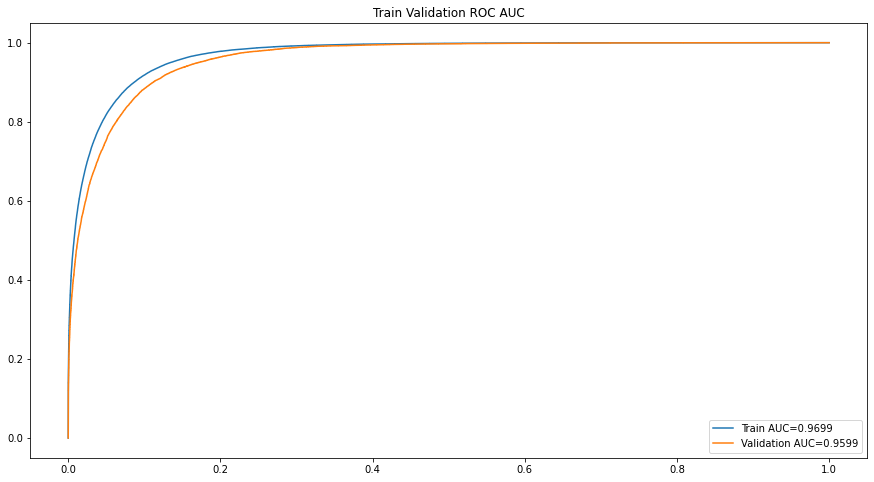

In [34]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

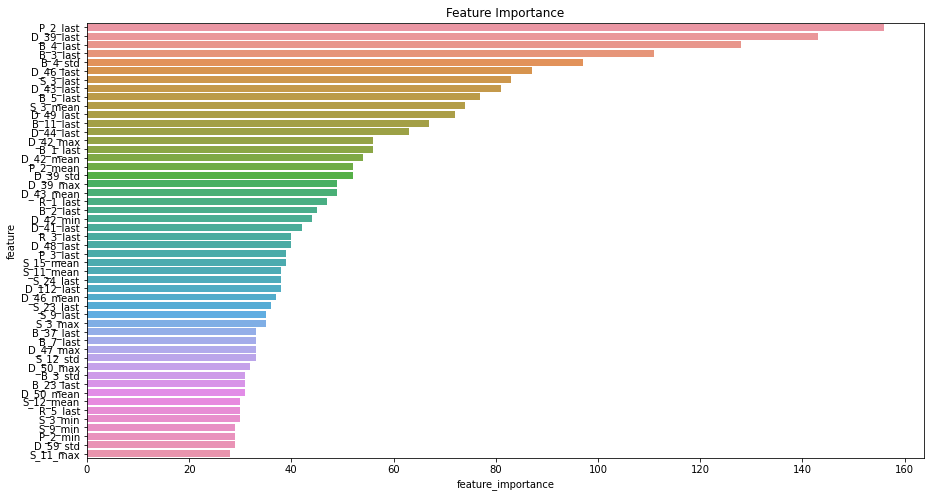

In [35]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [41]:
feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]

In [42]:
selected_features = imp_df.loc[imp_df["feature_importance"] > feature_imp_thr]["feature"].tolist()
len(selected_features)

270

#### Final x2 LGBM

In [43]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [44]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [45]:
final_lgbm_clf.fit(X_train_, y_train)

LGBMClassifier(colsample_bytree=0.7563114159768082,
               learning_rate=0.09325683729486695, max_depth=13,
               min_child_samples=31, min_split_gain=0.02118407062707835,
               n_estimators=110, num_leaves=76, random_state=1020, reg_lambda=4,
               subsample=0.8635875607027377, subsample_freq=4)

In [46]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

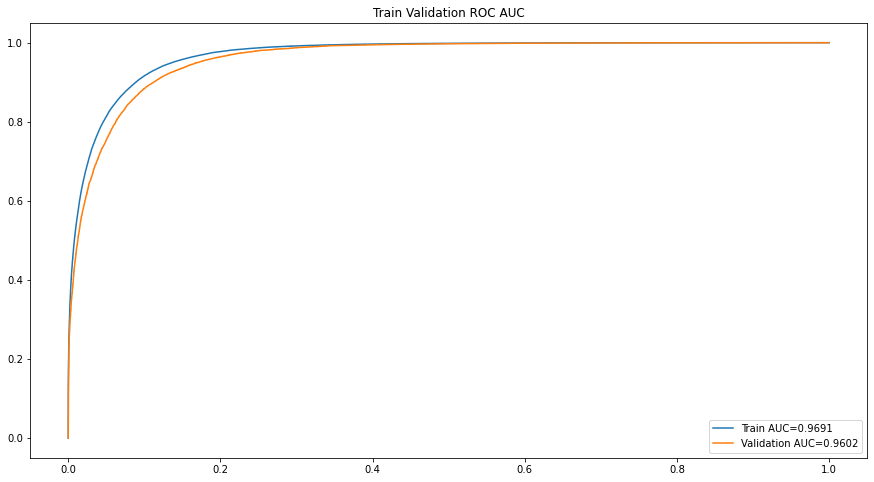

In [47]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [67]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_train_pred_df = pd.DataFrame(y_train_pred_).rename(columns={0: "prediction"})

In [68]:
amex_metric(y_train_df, y_train_pred_df)

0.8261566192430607

In [69]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [70]:
amex_metric(y_val_df, y_val_pred_df)

0.7866702328553711

In [ ]:
# num_list, num_features_list, train_score_list, val_score_list = [], [], [], []
# for i in tqdm(range(30)):
#     selected_features = imp_df.loc[imp_df["feature_importance"] > i]["feature"].tolist()
#     print(f"# of features: {len(selected_features)}")
    
#     X_train_new = train.loc[:, selected_features]
#     X_val_new = val.loc[:, selected_features]
    
#     lgbm_clf = LGBMClassifier(random_state=1020)
#     lgbm_clf.fit(X_train_new, y_train)
    
#     y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
#     y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
#     y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
#     y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
#     y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
#     y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
#     train_score = amex_metric(y_train_df, y_train_pred_df)
#     val_score = amex_metric(y_val_df, y_val_pred_df)
#     num_list.append(i)
#     num_features_list.append(len(selected_features))
#     train_score_list.append(train_score)
#     val_score_list.append(val_score)

In [ ]:
# eval_df = pd.DataFrame(dict(index_=num_list, 
#                             num_feature=num_features_list, 
#                             train_score=train_score_list, 
#                             val_score=val_score_list))

In [ ]:
# plt.figure(figsize=(17, 6))
# plt.plot(eval_df["index_"], eval_df["train_score"], label="Train")
# plt.plot(eval_df["index_"], eval_df["val_score"], label="Validation")
# plt.legend()
# plt.show()

In [75]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [76]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### Inference

In [79]:
X_test = test_data.loc[:, selected_features]

In [80]:
y_test_pred = loaded_lgbm_model.predict_proba(X_test)[:, 1]

In [82]:
test_data["prediction"] = y_test_pred

In [83]:
test_data.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,record_per_day,has_D_110_mean,has_D_111_mean,has_D_132_mean,has_D_134_mean,has_D_135_mean,has_D_136_mean,has_D_137_mean,has_D_138_mean,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.601562,0.020198,0.568848,0.631348,0.568848,0.069763,0.103129,0.001912,0.238770,...,26.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043517
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.862305,0.031432,0.794434,0.913574,0.841309,0.154297,0.177177,0.001548,0.505859,...,27.538462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001240
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.749023,0.061435,0.673340,0.834961,0.697754,0.181885,0.264004,0.000482,0.679688,...,29.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023857
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.474609,0.028883,0.428467,0.514160,0.513184,0.470459,0.128948,0.212524,0.683594,...,29.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219452
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.323975,0.049886,0.254395,0.425781,0.254395,0.353027,0.196611,0.035065,0.768066,...,28.461538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.854858


#### Submission

In [84]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [85]:
submission = submission.drop(columns="prediction")

In [86]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

In [88]:
# result.to_csv(f"{SUBMISSION_DATA_PATH}/submission4.csv", index=False)